# Generating data from GMM using Generative Adversarial Networks (GAN)

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline

import time

plt.rcParams['figure.figsize'] = 12, 12
np.random.seed(12345)

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)
/media/verinov/Work/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[0,-1],
         [1,2],
         [-1,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.3,
        0.3,
        0.4
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20

def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

In [3]:
def vis_data(data):
    hist = np.histogram2d(data[:,0], data[:,1], bins=100, range=[[-4,4],[-4,4]])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.2)

fixed_noise = sample_noise(100000)
def vis_g():
    data = g_generate(fixed_noise)
    if np.isnan(data).any():
        return
    hist = np.histogram2d(data[:,0], data[:,1], bins=100, range=[[-4,4],[-4,4]])
    plt.contour(hist[1][:-1], hist[2][:-1], hist[0])
    
def vis_d():
    X, Y = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    X = X.flatten()
    Y = Y.flatten()
    grads = d_grad(fixed_noise, np.vstack([X, Y]).T.astype(np.float32))
    plt.quiver(X, Y, grads[:,0], grads[:,1], color='red')

In [4]:
# generator
tnoise = T.matrix('z')
l = lgen_input = lasagne.layers.InputLayer((None, NOISE_DIM), tnoise)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.tanh)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.leaky_rectify)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.tanh)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.leaky_rectify)
lgen_output = lasagne.layers.DenseLayer(l, num_units = 2,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.identity)
tgen_output = lasagne.layers.get_output(lgen_output)

# discriminator
tdata = T.matrix('x')
l                = lasagne.layers.InputLayer((None, 2), tgen_output)
ld = ldisc_input = lasagne.layers.InputLayer((None, 2), tdata)

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.tanh,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.tanh,
                  **{v.name:v for v in l.params.keys()})

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  **{v.name:v for v in l.params.keys()})

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  **{v.name:v for v in l.params.keys()})

l = ldisc_output = lasagne.layers.DenseLayer(l, num_units = 1,
                  nonlinearity=lasagne.nonlinearities.sigmoid,
                  W=lasagne.init.GlorotNormal())
ld = lddisc_output = lasagne.layers.DenseLayer(ld, num_units = 1,
                  nonlinearity=lasagne.nonlinearities.sigmoid,
                  **{v.name:v for v in l.params.keys()})



tdisc_output = lasagne.layers.get_output(ldisc_output)
tddisc_output = lasagne.layers.get_output(lddisc_output)

g_loss = (T.log1p(-tdisc_output)).mean()
d_loss = -(T.log(tddisc_output) + T.log1p(-tdisc_output)).mean()
d_accuracy = ((tddisc_output > 0.5).mean() + (tdisc_output < 0.5).mean())/2

lr = theano.shared(np.float32(0.001))

g_params = lasagne.layers.get_all_params(lgen_output, trainable=True)
g_updates = lasagne.updates.nesterov_momentum(g_loss, g_params, learning_rate=lr, momentum=0.9)
g_step = theano.function([tnoise], g_loss, updates=g_updates)
g_generate = theano.function([tnoise], tgen_output)

d_params = lasagne.layers.get_all_params(lddisc_output, trainable=True)
d_updates = lasagne.updates.nesterov_momentum(d_loss, d_params, learning_rate=lr, momentum=0.9)
d_step = theano.function([tnoise, tdata], d_loss, updates=d_updates)
d_grad = theano.function([tnoise, tdata], T.grad(d_loss, tdata))
d_accuracy = theano.function([tnoise, tdata], d_accuracy)

In [5]:
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in xrange(0, X.shape[0], batchsize):
        end = min(start+batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


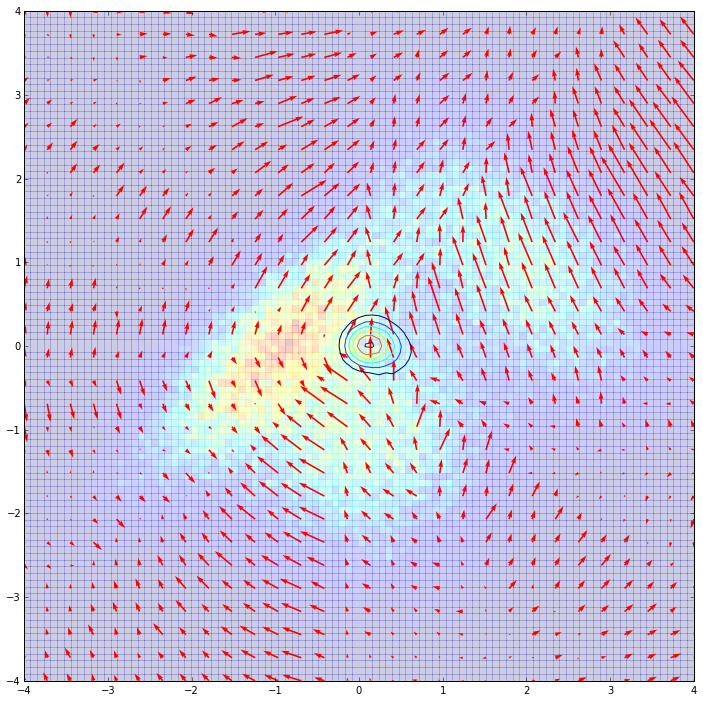

In [6]:
data = sample_true(100000)
vis_data(data)
vis_g()
vis_d()

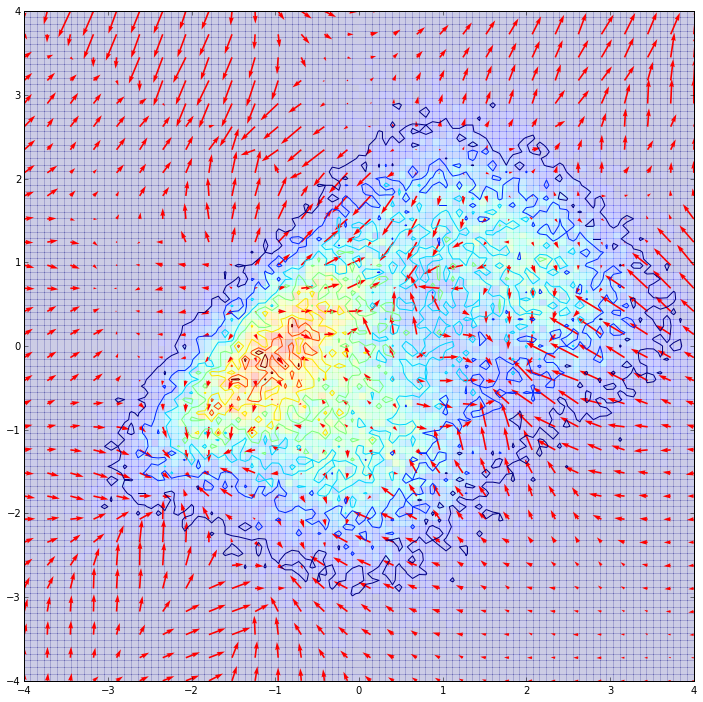

Learing rate: 0.0000490
Epoch 100 of 100 took 22.574s, dloss=1.3837, gloss=-0.69168, disc accuracy=0.53209
CPU times: user 25min 3s, sys: 10min 56s, total: 36min
Wall time: 35min 59s


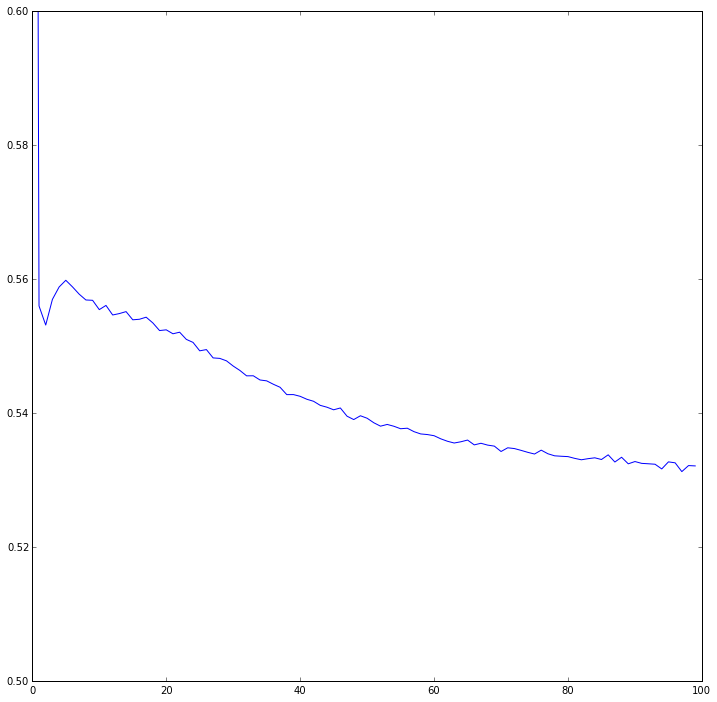

In [7]:
%%time
from IPython import display

plt.xlim((-4,4))
plt.ylim((-4,4))

num_epochs = 100
batch_size = 1024

lr_factor = np.float32(0.97)
k_d, k_g = 10, 1

accs = []

try:
    for epoch in range(num_epochs):
        d_loss_sum = 0.
        g_loss_sum = 0.
        d_accuracy_sum = 0.
        start_time = time.time()
        for input_data in iterate_minibatches(data, batch_size):
            for _ in range(k_d):
                noise = sample_noise(len(input_data))
                d_loss_sum += d_step(noise, input_data)/k_d
                d_accuracy_sum += d_accuracy(noise, input_data)/k_d
            for _ in range(k_g):
                g_loss_sum += g_step(sample_noise(batch_size))/k_g
            
        plt.clf()
        vis_data(data)
        vis_g()
        vis_d()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        print "Learing rate: %.7f"%lr.get_value()
        lr.set_value(lr.get_value() * lr_factor)

        acc = d_accuracy_sum/len(data)*batch_size
        dloss = d_loss_sum/len(data)*batch_size
        gloss = g_loss_sum/len(data)*batch_size
        print("Epoch {} of {} took {:.3f}s, dloss={:.5}, gloss={:.5}, disc accuracy={:.5}".format(
            epoch + 1, num_epochs, time.time() - start_time, dloss, gloss, acc))
        accs.append(acc)
        
except KeyboardInterrupt:
    pass
plt.clf()
plt.plot(accs)
plt.ylim((0.5,0.6))

On the plot above:
1. heatmap shows true data distribution
2. level lines show distribution of generated data on fixed noise sample
3. arrows show gradient of discriminator loss by data input, so generated distribution should tend in an opposite  direction (arrows show "tension")

10x handicap was introduces to give discriminator more chances.